# 5.9 (c) p.351
## 学習率の自動減衰

<code>
tensorflow.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # 監視対象 'val_loss' or 'val_accuracy'
    factor=0.1,          # 学習率を減らす割合 new_lr = lr * factor
    patience=10,         # 改善が見られないのを許容するエポック数
    verbose=0,           # 学習率削減時にメッセージを表示する(1) or しない(0)
    mode='auto',         # 'min'/'max'/'auto': {減少/増加/自動で判断}が止まったときに学習率を更新
    epsilon=0.0001,      # 改善があったと判断する閾値
    cooldown=0,          # 学習率を減らした後、通常の学習を再開するまで待機するエポック数
    min_lr=0             # 学習率の下限
    )
</code>

### 5.9 (b) と同様に、5.2 (b) のコードを転載する

In [1]:
# 5-02-20 CIFAR-10 データセットの読み込み
# p.312

from tensorflow.keras import datasets

(x_train, t_train), (x_test, t_test) = datasets.cifar10.load_data()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [3]:
# 5-02-21 CNN モデルの構築
# p.312
# [自分へのメモ] 関数呼び出しでモデルを作るように変更した。これで複数のモデルを作成して実験できる。

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers

def CNN(input_dim, output_dim):
    weight_decay = 1e-4
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(filters=32,kernel_size=(3,3),input_shape=input_dim,padding='same',kernel_regularizer=regularizers.l2(weight_decay),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(weight_decay),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding='same',kernel_regularizer=regularizers.l2(weight_decay),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dense(output_dim,activation='softmax'))
    return model

In [9]:
learning_rate = 0.1

model3 = CNN(x_train.shape[1:], 10)
model3.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=learning_rate),
    metrics=['accuracy']
    )

In [10]:
t_train_cat = tf.keras.utils.to_categorical(t_train, 10)
t_test_cat = tf.keras.utils.to_categorical(t_test, 10)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size=64

datagen3 = ImageDataGenerator(
    rescale=1.0/255.0, ### [0,1]に正規化
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
    )
datagen3.fit(x_train)
training_generator3 = datagen3.flow(
    x_train,   ### [0,255]
    t_train_cat,
    batch_size=batch_size,
    subset='training'
    )

validation_generator3 = datagen3.flow(
    x_train,   #### [0,255]
    t_train_cat,
    batch_size=batch_size,
    subset='validation'
    )

### 5回続けて改善されなければ学習率を半分にする

In [12]:
# 5-09-6 Kerasスタイルのプログラム p.316 を学習率の自動減衰対応に対応させる
# p.352
# [自分へのメモ] 学習部分だけを記述している

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    verbose=1,
    mode='max',
    min_lr = 0.0001)

In [13]:
epochs = 100

history3 = model3.fit(
    training_generator3,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator3,
    callbacks=[reduce_lr]
    )

Epoch 1/100
625/625 [==============================] - 24s 38ms/step - loss: 2.0337 - accuracy: 0.2660 - val_loss: 1.6778 - val_accuracy: 0.4082
Epoch 2/100
625/625 [==============================] - 24s 38ms/step - loss: 1.6102 - accuracy: 0.4274 - val_loss: 1.4619 - val_accuracy: 0.4758
Epoch 3/100
625/625 [==============================] - 24s 38ms/step - loss: 1.4613 - accuracy: 0.4831 - val_loss: 1.4938 - val_accuracy: 0.4677
Epoch 4/100
625/625 [==============================] - 24s 38ms/step - loss: 1.3573 - accuracy: 0.5253 - val_loss: 1.2898 - val_accuracy: 0.5495
Epoch 5/100
625/625 [==============================] - 24s 38ms/step - loss: 1.2722 - accuracy: 0.5569 - val_loss: 1.3483 - val_accuracy: 0.5301
Epoch 6/100
625/625 [==============================] - 24s 38ms/step - loss: 1.1979 - accuracy: 0.5889 - val_loss: 1.1092 - val_accuracy: 0.6279
Epoch 7/100
625/625 [==============================] - 23s 38ms/step - loss: 1.1534 - accuracy: 0.6061 - val_loss: 1.0924 - val_ac

625/625 [==============================] - 24s 38ms/step - loss: 0.4762 - accuracy: 0.8645 - val_loss: 0.6363 - val_accuracy: 0.8119
Epoch 56/100
625/625 [==============================] - 24s 38ms/step - loss: 0.4723 - accuracy: 0.8641 - val_loss: 0.6412 - val_accuracy: 0.8148
Epoch 57/100
624/625 [============================>.] - ETA: 0s - loss: 0.4694 - accuracy: 0.8644 ETA: 3s - loss: 0.4693 
Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.
625/625 [==============================] - 23s 38ms/step - loss: 0.4696 - accuracy: 0.8644 - val_loss: 0.6436 - val_accuracy: 0.8093
Epoch 58/100
625/625 [==============================] - 23s 37ms/step - loss: 0.4350 - accuracy: 0.8775 - val_loss: 0.6276 - val_accuracy: 0.8188
Epoch 59/100
625/625 [==============================] - 24s 38ms/step - loss: 0.4331 - accuracy: 0.8782 - val_loss: 0.6134 - val_accuracy: 0.8197
Epoch 60/100
625/625 [==============================] - 24s 38ms/step - loss: 0.4266 - accuracy:

In [20]:
print(history3.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [23]:
# 5-02-23 損失と精度の推移をグラフにする
# p.317
# [自分へのメモ] 独自のコードで書き直した

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history):
    fig, ax = plt.subplots(1, 3, figsize=(6*3.6, 4))
    
    ax[0].plot(history['accuracy'], "-", label="accuracy",c="blue")
    ax[0].plot(history['val_accuracy'], "-", label="val_accuracy",c="green")
    ax[0].set_title('model accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(loc="lower right")
    
    ax[1].plot(history['loss'], "-", label="loss", c="blue")
    ax[1].plot(history['val_loss'], "-", label="val_loss", c="green")
    ax[1].set_title('model loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(loc="upper left")
    
    ax[2].plot(history['lr'], "-", label="learning rate",c="blue")
    ax[2].set_title('Learning Rate')
    ax[2].set_xlabel('epoch')
    ax[2].set_ylabel('learning rate')
    ax[2].grid()
    ax[2].legend(loc="upper right")

    plt.subplots_adjust(wspace=0.2)
    plt.show()

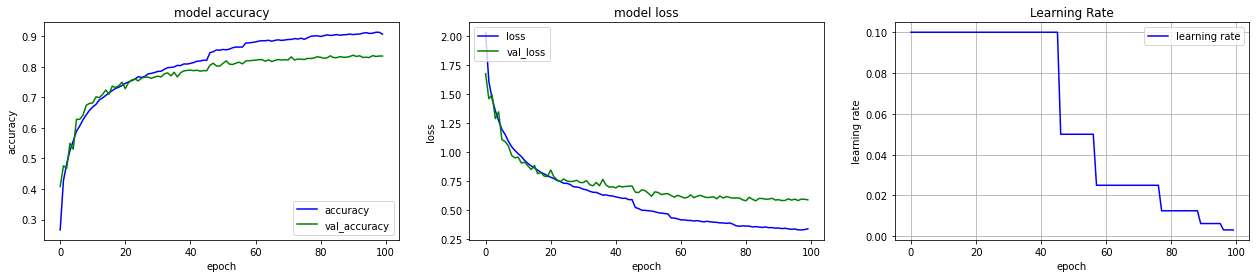

In [24]:
plot_history(history3.history)